## Shortlist Promising Models - Decision Tree Classifier

#### 0. Import modules and define parameters

In [1]:
import sys
sys.path.append("..")

from module.utils import general_utils
from module.utils import data_prepare_utils
from module.utils import model_performance_utils
import module.utils.bin_class_utils as bin_class_utils

from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_df_file = "../data/train_df.csv"

target_attr = "label"
target_type = "binary"

estimator_name = "DecisionTreeClassifier"

sample_random_state = 24
target_encoding_random_state = 42
model_random_state = 42
permutation_importance_random_state = 0
train_validation_split_random_state = 24

#### 1. Import Data

In [3]:
train_df = general_utils.read_csv(train_df_file)


Read CSV file ../data/train_df.csv into DataFrame:
df.head(): 


,uid,task_id,adv_id,creat_type_cd,adv_prim_id,dev_id,inter_type_cd,slot_id,spread_app_id,tags,...,device_price,up_life_duration,up_membership_grade,membership_life_duration,consume_purchase,communication_onlinerate,communication_avgonline_30d,indu_name,pt_d,label
0,1641431,5177,1998,7,191,60,5,21,82,14,...,2,-1,-1,-1,2,-1,6,24,3,0
1,2021896,4628,4530,7,177,56,5,17,31,40,...,3,18,-1,-1,2,10^11^12^13^14^15^16^17^18^19^20^21^22^23,7,17,3,0
2,1790795,2709,1413,7,134,55,4,17,65,18,...,5,20,-1,-1,5,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,13,14,1,0
3,1216709,1949,6143,7,150,17,5,21,11,39,...,2,16,-1,-1,2,8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,36,3,0
4,1635521,4806,2176,7,206,64,5,15,22,39,...,4,20,-1,-1,2,6^7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,36,1,0


df.shape: (838142, 36)


#### 2. Sample smaller training sets for fast exploration

In [4]:
train_df_sample = data_prepare_utils.sample_data(train_df, 0.01, random_state=sample_random_state)


Sample 0.01 fraction from DataFrame:
sample_df.shape: (8381, 36)


In [5]:
train_df_sample.reset_index(drop=True, inplace=True)

In [6]:
# train/validation split and check the distribution
from sklearn.model_selection import train_test_split

cap_x_df, y_df = train_df_sample.drop(columns=target_attr), train_df_sample[[target_attr]]

train_validation_split_random_state = 24
validation_size = 0.20
train_cap_x_df, validation_cap_x_df, train_y_df, validation_y_df = train_test_split(cap_x_df, y_df, test_size=validation_size, random_state=train_validation_split_random_state, stratify=y_df)
train_df_exp = pd.concat([train_cap_x_df, train_y_df], axis = 1)
train_df_exp.to_csv('train_df_exp.csv', index=False)
validation_df_exp = pd.concat([validation_cap_x_df, validation_y_df], axis = 1)
validation_df_exp.to_csv('validation_df_exp.csv', index=False)

In [7]:
print('Distribution in train_df\n', train_df[target_attr].value_counts(normalize=True), '\n')
print('Distribution in train_df_sample\n', train_df_sample[[target_attr]].value_counts(normalize=True), '\n')
print('Distribution in train_y_df\n', train_y_df.value_counts(normalize=True), '\n')
print('Distribution in validation_y_df\n', validation_y_df.value_counts(normalize=True), '\n')

Distribution in train_df
 label
0    0.965507
1    0.034493
Name: proportion, dtype: float64 

Distribution in train_df_sample
 label
0        0.965517
1        0.034483
Name: proportion, dtype: float64 

Distribution in train_y_df
 label
0        0.965543
1        0.034457
Name: proportion, dtype: float64 

Distribution in validation_y_df
 label
0        0.965414
1        0.034586
Name: proportion, dtype: float64 



#### 3. Check attribute types

In [8]:
numerical_attr_list = []
categorical_attr_list = [attr for attr in train_cap_x_df.columns if attr not in numerical_attr_list and attr != target_attr]
attr_list = numerical_attr_list + categorical_attr_list

#### ! Unbalance
- Assess unbalance: Based on the distribution printed above, the distribution is unbalanced. 
- Steps to deal with unbalanced classes

In [9]:
# possible options for class_weight hyperparameter
balanced = train_y_df.shape[0] / (train_y_df[target_attr].nunique()*np.bincount(train_y_df[target_attr]))
balanced_dict = \
    dict(
        zip(
            train_y_df[target_attr].unique(), 
            balanced
        )
    )
balanced_and_normalized_dict = \
    dict(
        zip(
            train_y_df[target_attr].unique(),
            balanced/sum(balanced)
            )
        )
class_weight_options_dict = {
    'None': None,
    'balanced mode': 'balanced',
    'balanced computed': balanced_dict,
    'balanced_and_normalized': balanced_and_normalized_dict
}

#### 4. Predefined data processing strategy in prep.ipynb

In [10]:
# train_df_sample = data_prepare_utils.drop_duplicate_obs(train_df_sample) modify required

In [11]:
attrs_to_drop = ['app_score', 'his_on_shelf_time', 'task_id', 'spread_app_id', 'tags', 'dev_id', 'app_second_class', 'adv_prim_id', 'device_price']


preprocessor = bin_class_utils.build_preprocessing_pipeline(numerical_attr_list, categorical_attr_list, attrs_to_drop, target_type, target_encoding_random_state)

#### 5. Define default model

In [12]:
estimator = DecisionTreeClassifier(random_state=model_random_state)

#### 6. Define composite model train set

In [13]:
composite_estimator = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', estimator)])

In [14]:
composite_estimator.fit(
    train_cap_x_df, 
    train_y_df.values.ravel()
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('column_dropper',
                                                                   DropColumnsTransformer(attrs_to_drop=['app_score',
                                                                                                         'his_on_shelf_time',
                                                                                                         'task_id',
                                                                                                         'spread_app_id',
                                                                                                         'tags',
                                                                                                         'dev_id',
                                                                                                         'app_second_class',
                                                                                                         'adv_prim_id',
                                                                                                         'device_price'])),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('categorical'...
                                                   'spread_app_id', 'tags',
                                                   'app_first_class',
                                                   'app_second_class', 'age',
                                                   'city', 'city_rank',
                                                   'device_name', 'device_size',
                                                   'career', 'gender',
                                                   'net_type', 'residence',
                                                   'his_app_size',
                                                   'his_on_shelf_time',
                                                   'app_score', 'emui_dev',
                                                   'list_time', 'device_price',
                                                   'up_life_duration',
                                                   'up_membership_grade',
                                                   'membership_life_duration', ...])])),
                ('estimator', DecisionTreeClassifier(random_state=42))])

#### 7. Check the most significant attributes

In [15]:
permutation_df = bin_class_utils.check_out_permutation_importance(
    composite_estimator, 
    train_cap_x_df, 
    train_y_df, 
    permutation_importance_random_state
)

permutation_df


Permutation importance:


,Feature,sqrt_neg_mean_squared_error
0,slot_id,0.074 +/- 0.039
1,adv_id,0.070 +/- 0.034
2,emui_dev,0.060 +/- 0.025
3,device_size,0.057 +/- 0.037
4,net_type,0.056 +/- 0.023
5,communication_onlinerate,0.055 +/- 0.037
6,indu_name,0.049 +/- 0.019
7,his_app_size,0.048 +/- 0.026
8,age,0.044 +/- 0.026
9,gender,0.038 +/- 0.021


#### 8. Evaluate the performance of the trained default estimators on the train set
Based on the confusion matrix, 7956 (7906 + 50) predictions are correct and 424 (239 + 185) predictions are incorrect. - modify required

Check accuracy score
train set set accuracy score: 0.9433174224343676

Check confusion matrix
train set set confusion matrix: 
[[6284  189]
 [ 191   40]]
True Positives =  6284
True Negatives =  40
False Positives(Type I error) =  189
False Negatives(Type II error) =  191

Check classification report
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      6473
           1       0.17      0.17      0.17       231

    accuracy                           0.94      6704
   macro avg       0.57      0.57      0.57      6704
weighted avg       0.94      0.94      0.94      6704


Check the ROC Curve and AUC


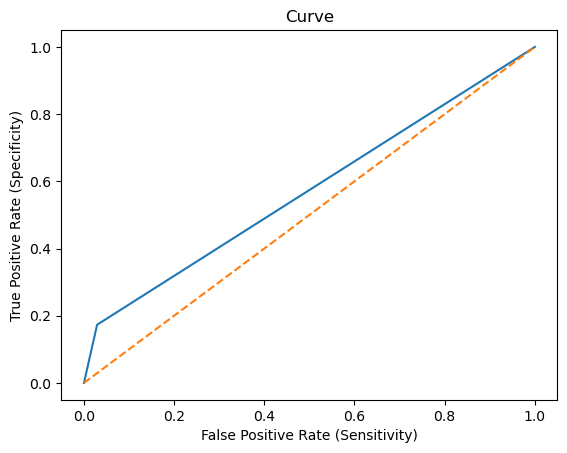


Check Precision-Recall Curve and Average Precision Score


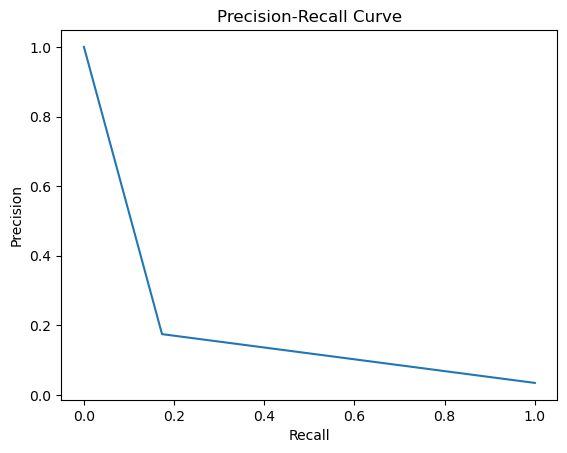

The roc_auc_score:  0.5719809826097483
Average Precision Score:  0.058736771916545964


(0.5719809826097483, 0.058736771916545964)

In [16]:
bin_class_utils.eval_class(train_cap_x_df, train_y_df, composite_estimator, 'train set')

#### 9. Performance with different class_weight hyperparameter

Check accuracy score
train sample set accuracy score: 0.9433174224343676

Check confusion matrix
train sample set confusion matrix: 
[[6284  189]
 [ 191   40]]
True Positives =  6284
True Negatives =  40
False Positives(Type I error) =  189
False Negatives(Type II error) =  191

Check classification report
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      6473
           1       0.17      0.17      0.17       231

    accuracy                           0.94      6704
   macro avg       0.57      0.57      0.57      6704
weighted avg       0.94      0.94      0.94      6704


Check the ROC Curve and AUC


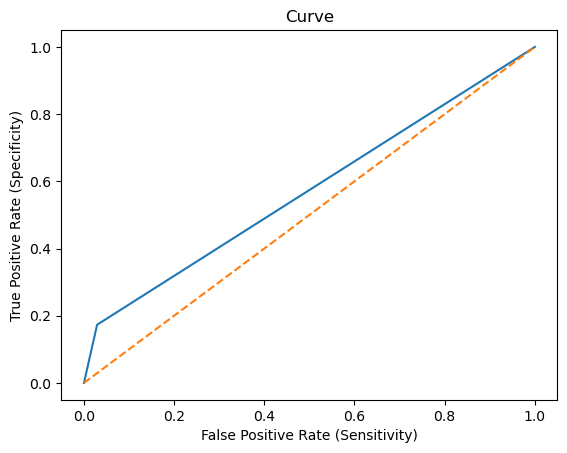


Check Precision-Recall Curve and Average Precision Score


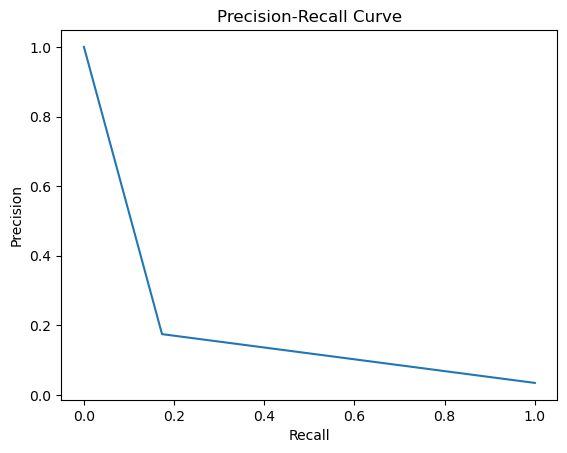

The roc_auc_score:  0.5719809826097483
Average Precision Score:  0.058736771916545964
Check accuracy score
train sample set accuracy score: 0.9467482100238663

Check confusion matrix
train sample set confusion matrix: 
[[6306  167]
 [ 190   41]]
True Positives =  6306
True Negatives =  41
False Positives(Type I error) =  167
False Negatives(Type II error) =  190

Check classification report
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      6473
           1       0.20      0.18      0.19       231

    accuracy                           0.95      6704
   macro avg       0.58      0.58      0.58      6704
weighted avg       0.94      0.95      0.95      6704


Check the ROC Curve and AUC


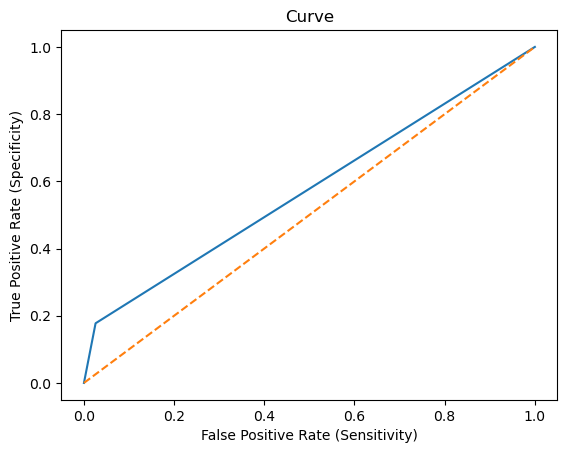


Check Precision-Recall Curve and Average Precision Score


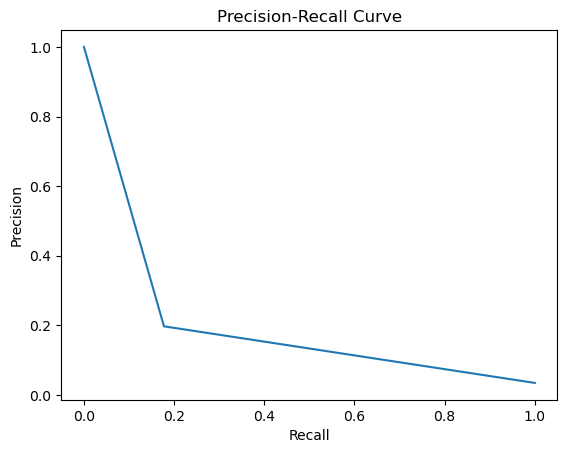

The roc_auc_score:  0.5758448513739723
Average Precision Score:  0.06332713626866372
Check accuracy score
train sample set accuracy score: 0.9467482100238663

Check confusion matrix
train sample set confusion matrix: 
[[6306  167]
 [ 190   41]]
True Positives =  6306
True Negatives =  41
False Positives(Type I error) =  167
False Negatives(Type II error) =  190

Check classification report
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      6473
           1       0.20      0.18      0.19       231

    accuracy                           0.95      6704
   macro avg       0.58      0.58      0.58      6704
weighted avg       0.94      0.95      0.95      6704


Check the ROC Curve and AUC


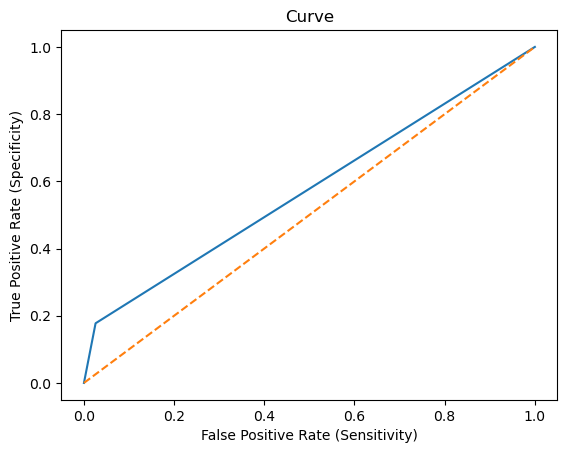


Check Precision-Recall Curve and Average Precision Score


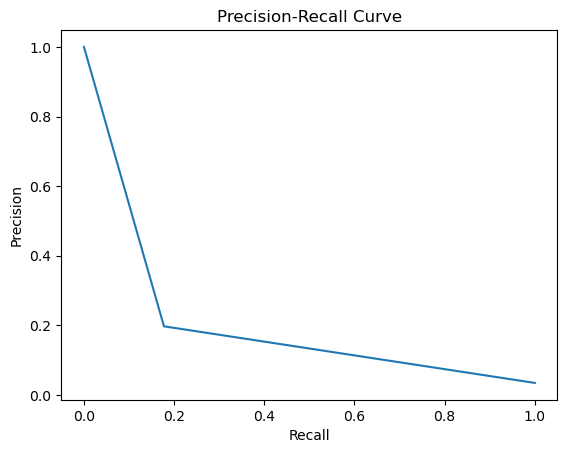

The roc_auc_score:  0.5758448513739723
Average Precision Score:  0.06332713626866372
Check accuracy score
train sample set accuracy score: 0.9504773269689738

Check confusion matrix
train sample set confusion matrix: 
[[6322  151]
 [ 181   50]]
True Positives =  6322
True Negatives =  50
False Positives(Type I error) =  151
False Negatives(Type II error) =  181

Check classification report
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      6473
           1       0.25      0.22      0.23       231

    accuracy                           0.95      6704
   macro avg       0.61      0.60      0.60      6704
weighted avg       0.95      0.95      0.95      6704


Check the ROC Curve and AUC


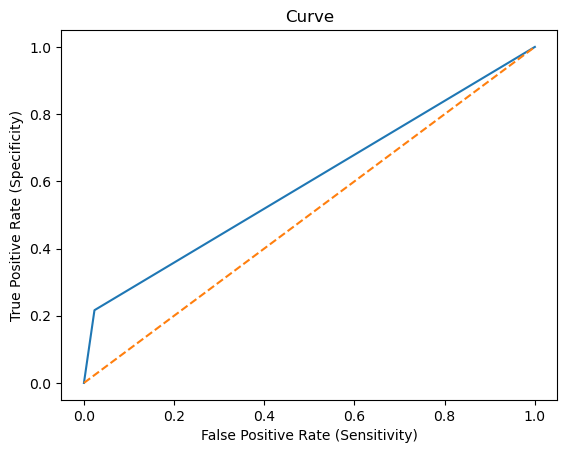


Check Precision-Recall Curve and Average Precision Score


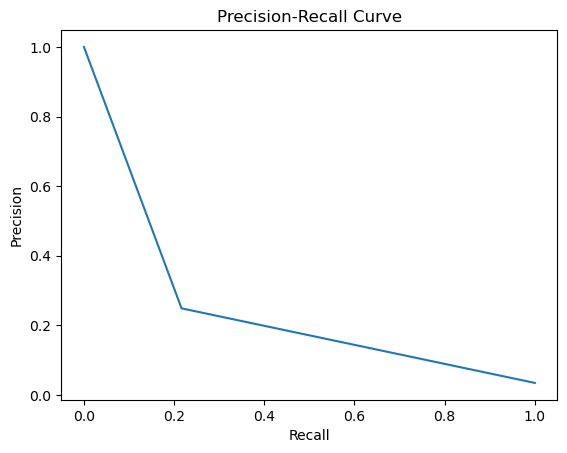

The roc_auc_score:  0.5965612738361078
Average Precision Score:  0.08084214410800454


,class_weight_name,class imbalance class 0,class imbalance class 1,roc_curve_auc,ave_precision_score,data_set
0,None,0.965543,0.034457,0.571981,0.058737,train
1,balanced mode,0.965543,0.034457,0.575845,0.063327,train
2,balanced computed,0.965543,0.034457,0.575845,0.063327,train
3,balanced_and_normalized,0.965543,0.034457,0.596561,0.080842,train


In [17]:
perf_dict_list = []

for class_weight_name, class_weight_option in class_weight_options_dict.items():
    estimator = DecisionTreeClassifier(random_state=model_random_state, class_weight=class_weight_option)
    
    composite_estimator = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', estimator)])

    roc_auc, ave_precision = \
        bin_class_utils.eval_class(train_cap_x_df, train_y_df, composite_estimator, 'train sample')
    row_dict = {
        'class_weight_name': class_weight_name,
        'class imbalance class 0': train_y_df[target_attr].value_counts(normalize=True).loc[0],
        'class imbalance class 1': train_y_df[target_attr].value_counts(normalize=True).loc[1],
        'roc_curve_auc': roc_auc,
        'ave_precision_score': ave_precision,
        'data_set': 'train'
    }
    perf_dict_list.append(row_dict)
    
perf_dict_df = pd.DataFrame(perf_dict_list)
perf_dict_df

#### 10. Evaluate the performance of the trained default estimators on the validation set

Check accuracy score
validation set set accuracy score: 0.9212880143112702

Check confusion matrix
validation set set confusion matrix: 
[[1539   80]
 [  52    6]]
True Positives =  1539
True Negatives =  6
False Positives(Type I error) =  80
False Negatives(Type II error) =  52

Check classification report
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1619
           1       0.07      0.10      0.08        58

    accuracy                           0.92      1677
   macro avg       0.52      0.53      0.52      1677
weighted avg       0.94      0.92      0.93      1677


Check the ROC Curve and AUC


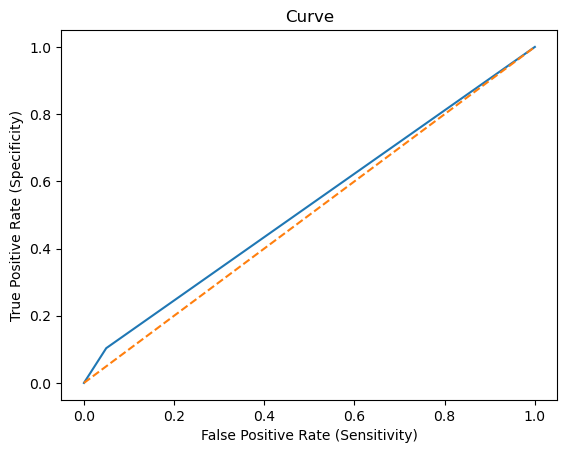


Check Precision-Recall Curve and Average Precision Score


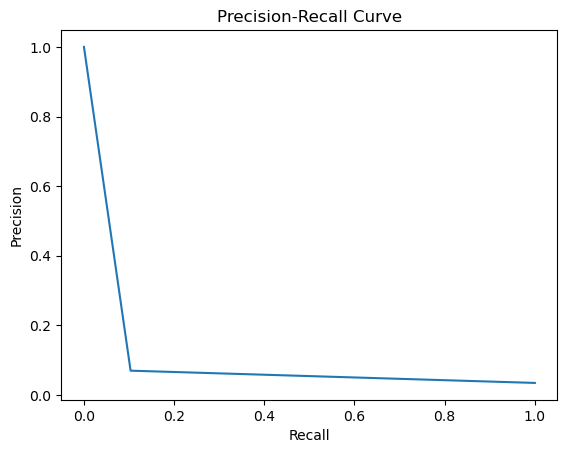

The roc_auc_score:  0.5270175289131223
Average Precision Score:  0.03822507350975675


In [18]:
val_estimator = DecisionTreeClassifier(random_state=model_random_state, class_weight=balanced_and_normalized_dict)
    
val_composite_estimator = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', val_estimator)])

val_roc_auc, val_ave_precision = \
    bin_class_utils.eval_class(validation_cap_x_df, validation_y_df, val_composite_estimator, 'validation set')
val_dict_list = {
    'class_weight_name': 'balanced_and_normalized',
    'roc_curve_auc': val_roc_auc,
    'ave_precision_score': val_ave_precision,
    'data_set': 'validation'
}
val_perf_dict_df = pd.DataFrame([val_dict_list])

In [19]:
# compare the performance on the train and validation set
uncompared_columns = ['class imbalance class 0', 'class imbalance class 1']
best_perf_dict_df = perf_dict_df[perf_dict_df['class_weight_name'] == 'balanced_and_normalized'].drop(columns = uncompared_columns)
pd.concat([best_perf_dict_df, val_perf_dict_df], ignore_index=True)

,class_weight_name,roc_curve_auc,ave_precision_score,data_set
0,balanced_and_normalized,0.596561,0.080842,train
1,balanced_and_normalized,0.527018,0.038225,validation


The scores in the validation set is lower. It's an indication of overfitting. The model fails to generalize well on new data. 

#### Other steps